# Regression using Pytorch

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from source.ffnn_model import WellLogFFNN
from source.ffnn_well_data_preprocessing import load_log_data

# Reproducibility, gotten from project 2
NP_RANDOM_SEED = 42
torch.manual_seed(NP_RANDOM_SEED)
np.random.seed(NP_RANDOM_SEED)


In [2]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(None)

print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:",   X_val.shape)
print("X_test:",  X_test.shape)



[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Shapes:
X_train: torch.Size([8699, 11])
y_train: torch.Size([8699, 1])
X_val: torch.Size([1864, 11])
X_test: torch.Size([1865, 11])


In [3]:
# Basic statistics of y_train
print("y_train min:", y_train.min().item())
print("y_train max:", y_train.max().item())
print("y_train mean:", y_train.mean().item())
print("y_train std:", y_train.std().item())


y_train min: -5.230142116546631
y_train max: 3.121978759765625
y_train mean: 1.2059336862435543e-09
y_train std: 1.0000574588775635


In [4]:
"""

Defining model and training function.

The model is a feedforward neural network defined in source/ffnn_model.py.

The training function uses MSE loss and Adam optimizer.

Code is adapted from project 2 part c.

"""

input_dim = X_train.shape[1]

# Defining model
def make_model(hidden_dims=(64, 64), dropout=0.2, activation=nn.ReLU):
    return WellLogFFNN(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        dropout=dropout,
        activation=activation,
    )
# Training function
def train_model(
    model,
    X_train, y_train,
    X_val,   y_val,
    lr: float = 1e-3,
    epochs: int = 100,
    verbose: bool = False,
):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    best_state_dict = None

    train_losses = []
    val_losses   = []

    for epoch in range(epochs):
        # ---- TRAIN ----
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # ---- VALIDATION ----
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()

        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:4d} | Train MSE: {loss.item():.4f} | Val MSE: {val_loss:.4f}")

    # last best weights
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    return model, best_val_loss, train_losses, val_losses


In [5]:
# Training with different configurations and evaluating on test set
configs = [
    {"name": "small_no_dropout",  "hidden_dims": (32, 32),        "lr": 1e-3, "dropout": 0.0},
    {"name": "medium_dropout",    "hidden_dims": (64, 64),        "lr": 1e-3, "dropout": 0.2},
    {"name": "deep_dropout",      "hidden_dims": (128, 64, 32),   "lr": 1e-4, "dropout": 0.2},
    {"name": "medium_lr_high",    "hidden_dims": (64, 64),        "lr": 1e-2, "dropout": 0.2},
]

results = []
histories = {}

for cfg in configs:
    print(f"\n=== Training config: {cfg['name']} ===")
    print(f"hidden_dims={cfg['hidden_dims']}, lr={cfg['lr']}, dropout={cfg['dropout']}")

    torch.manual_seed(NP_RANDOM_SEED)
    np.random.seed(NP_RANDOM_SEED)

    model = make_model(
        hidden_dims=cfg["hidden_dims"],
        dropout=cfg["dropout"],
        activation=nn.ReLU,
    )

    model, best_val_mse, train_losses, val_losses = train_model(
        model,
        X_train, y_train,
        X_val,   y_val,
        lr=cfg["lr"],
        epochs=100,
        verbose=False,
    )

    # evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
        test_mse = nn.MSELoss()(y_pred_test, y_test).item()

    results.append({
        "name":        cfg["name"],
        "hidden_dims": cfg["hidden_dims"],
        "lr":          cfg["lr"],
        "dropout":     cfg["dropout"],
        "val_mse":     best_val_mse,
        "test_mse":    test_mse,
    })

    histories[cfg["name"]] = {
        "train_losses": train_losses,
        "val_losses":   val_losses,
    }

results_df = pd.DataFrame(results)
display(results_df)



=== Training config: small_no_dropout ===
hidden_dims=(32, 32), lr=0.001, dropout=0.0

=== Training config: medium_dropout ===
hidden_dims=(64, 64), lr=0.001, dropout=0.2

=== Training config: deep_dropout ===
hidden_dims=(128, 64, 32), lr=0.0001, dropout=0.2

=== Training config: medium_lr_high ===
hidden_dims=(64, 64), lr=0.01, dropout=0.2


,name,hidden_dims,lr,dropout,val_mse,test_mse
0,small_no_dropout,"(32, 32)",0.0010,0.0,0.287912,0.283551
1,medium_dropout,"(64, 64)",0.0010,0.2,0.246029,0.248405
2,deep_dropout,"(128, 64, 32)",0.0001,0.2,0.767336,0.731396
3,medium_lr_high,"(64, 64)",0.0100,0.2,0.171233,0.178011


In [6]:
import optuna
from optuna.trial import Trial  

"""Objective function for Optuna hyperparameter optimization."""

# Define objective function for Optuna
def objective(trial):
    (X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(
        random_state=42
    )    
    
    
    # Suggest hyperparameters
    hidden_dim1 = trial.suggest_int("hidden_dim1", 16, 256, step=16)
    hidden_dim2 = trial.suggest_int("hidden_dim2", 16, 256, step=16)
    hidden_dim3 = trial.suggest_int("hidden_dim3", 16, 256, step=16)
    n_layers = trial.suggest_int("n_layers", 2, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    
    # Build hidden_dims tuple based on n_layers
    hidden_dims_list = [hidden_dim1, hidden_dim2, hidden_dim3][:n_layers]
    hidden_dims = tuple(hidden_dims_list)
    
    # Reset seeds for reproducibility
    torch.manual_seed(NP_RANDOM_SEED)
    np.random.seed(NP_RANDOM_SEED)
    
    # Create and train model
    model = make_model(
        hidden_dims=hidden_dims,
        dropout=dropout, 
        activation=nn.ReLU,
    )
    
    model, best_val_mse, _, _ = train_model(
        model,
        X_train, y_train,
        X_val, y_val,
        lr=lr,
        epochs=100,
        verbose=False,
    )
    
    return best_val_mse

# Create and run Optuna study
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(
    study_name="ffnn_regression_rs42_new",
    storage="sqlite:///optuna_study.db",
    direction="minimize",
    load_if_exists=False,
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

# Get best trial
best_trial = study.best_trial

print("\n" + "="*60)
print("OPTUNA OPTIMIZATION RESULTS")
print("="*60)
print(f"Best validation MSE: {best_trial.value:.6f}")
print("\nBest hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")
print("="*60)


/workspaces/project3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting Optuna hyperparameter optimization...


[I 2025-12-16 16:41:41,140] A new study created in RDB with name: ffnn_regression_rs42_new
  0%|          | 0/50 [00:00<?, ?it/s]

[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 0. Best value: 0.902729:   2%|▏         | 1/50 [00:08<06:33,  8.03s/it]

[I 2025-12-16 16:41:49,162] Trial 0 finished with value: 0.9027289152145386 and parameters: {'hidden_dim1': 112, 'hidden_dim2': 112, 'hidden_dim3': 160, 'n_layers': 4, 'dropout': 0.2, 'lr': 1.766383451409338e-05}. Best is trial 0 with value: 0.9027289152145386.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 1. Best value: 0.300585:   4%|▍         | 2/50 [00:14<05:51,  7.33s/it]

[I 2025-12-16 16:41:55,997] Trial 1 finished with value: 0.300585001707077 and parameters: {'hidden_dim1': 48, 'hidden_dim2': 32, 'hidden_dim3': 256, 'n_layers': 3, 'dropout': 0.4, 'lr': 0.0018394843233633352}. Best is trial 1 with value: 0.300585001707077.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 1. Best value: 0.300585:   6%|▌         | 3/50 [00:20<05:13,  6.67s/it]

[I 2025-12-16 16:42:01,878] Trial 2 finished with value: 0.4114057421684265 and parameters: {'hidden_dim1': 16, 'hidden_dim2': 32, 'hidden_dim3': 224, 'n_layers': 4, 'dropout': 0.5, 'lr': 0.0006829138269606792}. Best is trial 1 with value: 0.300585001707077.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 3. Best value: 0.255632:   8%|▊         | 4/50 [00:27<05:14,  6.83s/it]

[I 2025-12-16 16:42:08,952] Trial 3 finished with value: 0.2556317448616028 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 32, 'hidden_dim3': 96, 'n_layers': 3, 'dropout': 0.4, 'lr': 0.0010950868592093015}. Best is trial 3 with value: 0.2556317448616028.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 4. Best value: 0.229672:  10%|█         | 5/50 [00:34<04:58,  6.63s/it]

[I 2025-12-16 16:42:15,231] Trial 4 finished with value: 0.22967219352722168 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 96, 'hidden_dim3': 160, 'n_layers': 4, 'dropout': 0.30000000000000004, 'lr': 0.0014403743882693448}. Best is trial 4 with value: 0.22967219352722168.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 5. Best value: 0.199379:  12%|█▏        | 6/50 [00:35<03:29,  4.77s/it]

[I 2025-12-16 16:42:16,383] Trial 5 finished with value: 0.1993793398141861 and parameters: {'hidden_dim1': 112, 'hidden_dim2': 64, 'hidden_dim3': 144, 'n_layers': 2, 'dropout': 0.0, 'lr': 0.00281929121863108}. Best is trial 5 with value: 0.1993793398141861.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 6. Best value: 0.156892:  14%|█▍        | 7/50 [00:40<03:29,  4.87s/it]

[I 2025-12-16 16:42:21,480] Trial 6 finished with value: 0.1568920910358429 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 112, 'hidden_dim3': 16, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.006186626853946581}. Best is trial 6 with value: 0.1568920910358429.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 6. Best value: 0.156892:  16%|█▌        | 8/50 [00:42<02:43,  3.90s/it]

[I 2025-12-16 16:42:23,291] Trial 7 finished with value: 0.5274922847747803 and parameters: {'hidden_dim1': 64, 'hidden_dim2': 208, 'hidden_dim3': 112, 'n_layers': 2, 'dropout': 0.0, 'lr': 9.797180279178365e-05}. Best is trial 6 with value: 0.1568920910358429.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 6. Best value: 0.156892:  18%|█▊        | 9/50 [00:43<02:10,  3.19s/it]

[I 2025-12-16 16:42:24,939] Trial 8 finished with value: 0.5423205494880676 and parameters: {'hidden_dim1': 16, 'hidden_dim2': 80, 'hidden_dim3': 32, 'n_layers': 2, 'dropout': 0.2, 'lr': 0.00035355320738959426}. Best is trial 6 with value: 0.1568920910358429.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 6. Best value: 0.156892:  20%|██        | 10/50 [00:50<02:51,  4.29s/it]

[I 2025-12-16 16:42:31,684] Trial 9 finished with value: 0.28426826000213623 and parameters: {'hidden_dim1': 128, 'hidden_dim2': 48, 'hidden_dim3': 144, 'n_layers': 3, 'dropout': 0.5, 'lr': 0.0008231446642424685}. Best is trial 6 with value: 0.1568920910358429.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 10. Best value: 0.146528:  22%|██▏       | 11/50 [00:57<03:17,  5.07s/it]

[I 2025-12-16 16:42:38,527] Trial 10 finished with value: 0.14652760326862335 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 160, 'hidden_dim3': 16, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.006941800092721354}. Best is trial 10 with value: 0.14652760326862335.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 11. Best value: 0.14651:  24%|██▍       | 12/50 [01:04<03:35,  5.66s/it] 

[I 2025-12-16 16:42:45,525] Trial 11 finished with value: 0.14650988578796387 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 176, 'hidden_dim3': 16, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.005620015252456502}. Best is trial 11 with value: 0.14650988578796387.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 11. Best value: 0.14651:  26%|██▌       | 13/50 [01:13<04:06,  6.66s/it]

[I 2025-12-16 16:42:54,482] Trial 12 finished with value: 0.14659179747104645 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 176, 'hidden_dim3': 64, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.009631861579313363}. Best is trial 11 with value: 0.14650988578796387.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 11. Best value: 0.14651:  28%|██▊       | 14/50 [01:21<04:19,  7.20s/it]

[I 2025-12-16 16:43:02,927] Trial 13 finished with value: 0.14797280728816986 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 256, 'hidden_dim3': 48, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.0036842673088400392}. Best is trial 11 with value: 0.14650988578796387.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 11. Best value: 0.14651:  30%|███       | 15/50 [01:30<04:26,  7.60s/it]

[I 2025-12-16 16:43:11,464] Trial 14 finished with value: 0.27385345101356506 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 160, 'hidden_dim3': 80, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.00013662044552231243}. Best is trial 11 with value: 0.14650988578796387.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 11. Best value: 0.14651:  32%|███▏      | 16/50 [01:37<04:16,  7.54s/it]

[I 2025-12-16 16:43:18,869] Trial 15 finished with value: 0.1585196703672409 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 208, 'hidden_dim3': 16, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.005087001776052407}. Best is trial 11 with value: 0.14650988578796387.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 11. Best value: 0.14651:  34%|███▍      | 17/50 [01:40<03:21,  6.12s/it]

[I 2025-12-16 16:43:21,682] Trial 16 finished with value: 0.8318662047386169 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 144, 'hidden_dim3': 48, 'n_layers': 4, 'dropout': 0.0, 'lr': 3.0379673611299236e-05}. Best is trial 11 with value: 0.14650988578796387.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 11. Best value: 0.14651:  36%|███▌      | 18/50 [01:51<03:58,  7.47s/it]

[I 2025-12-16 16:43:32,284] Trial 17 finished with value: 0.16934292018413544 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 192, 'hidden_dim3': 112, 'n_layers': 4, 'dropout': 0.30000000000000004, 'lr': 0.009896131000679636}. Best is trial 11 with value: 0.14650988578796387.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 11. Best value: 0.14651:  38%|███▊      | 19/50 [01:56<03:31,  6.83s/it]

[I 2025-12-16 16:43:37,615] Trial 18 finished with value: 0.3016328811645508 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 144, 'hidden_dim3': 16, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.00023997660444262172}. Best is trial 11 with value: 0.14650988578796387.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 19. Best value: 0.145122:  40%|████      | 20/50 [02:02<03:18,  6.62s/it]

[I 2025-12-16 16:43:43,757] Trial 19 finished with value: 0.14512169361114502 and parameters: {'hidden_dim1': 240, 'hidden_dim2': 240, 'hidden_dim3': 192, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0030409309913273863}. Best is trial 19 with value: 0.14512169361114502.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 19. Best value: 0.145122:  42%|████▏     | 21/50 [02:09<03:12,  6.63s/it]

[I 2025-12-16 16:43:50,407] Trial 20 finished with value: 0.1475391685962677 and parameters: {'hidden_dim1': 240, 'hidden_dim2': 256, 'hidden_dim3': 192, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0025487154336167788}. Best is trial 19 with value: 0.14512169361114502.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.138929:  44%|████▍     | 22/50 [02:15<02:58,  6.36s/it]

[I 2025-12-16 16:43:56,146] Trial 21 finished with value: 0.13892917335033417 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 224, 'hidden_dim3': 192, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.00585932080340452}. Best is trial 21 with value: 0.13892917335033417.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  46%|████▌     | 23/50 [02:20<02:46,  6.18s/it]

[I 2025-12-16 16:44:01,913] Trial 22 finished with value: 0.13816143572330475 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 224, 'hidden_dim3': 192, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.003633596393720295}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  48%|████▊     | 24/50 [02:25<02:31,  5.82s/it]

[I 2025-12-16 16:44:06,893] Trial 23 finished with value: 0.20109206438064575 and parameters: {'hidden_dim1': 160, 'hidden_dim2': 224, 'hidden_dim3': 192, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0005353637309844019}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  50%|█████     | 25/50 [02:32<02:29,  5.98s/it]

[I 2025-12-16 16:44:13,241] Trial 24 finished with value: 0.15600456297397614 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 240, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0020239034222521895}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  52%|█████▏    | 26/50 [02:39<02:30,  6.26s/it]

[I 2025-12-16 16:44:20,168] Trial 25 finished with value: 0.13832449913024902 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 224, 'hidden_dim3': 240, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0036185281997020676}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  54%|█████▍    | 27/50 [02:42<02:06,  5.49s/it]

[I 2025-12-16 16:44:23,864] Trial 26 finished with value: 0.15569385886192322 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 224, 'hidden_dim3': 256, 'n_layers': 2, 'dropout': 0.0, 'lr': 0.004082635140291634}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  56%|█████▌    | 28/50 [02:49<02:08,  5.83s/it]

[I 2025-12-16 16:44:30,486] Trial 27 finished with value: 0.15813948214054108 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 208, 'hidden_dim3': 240, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.001414991392596839}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  58%|█████▊    | 29/50 [02:59<02:31,  7.22s/it]

[I 2025-12-16 16:44:40,955] Trial 28 finished with value: 0.5175825357437134 and parameters: {'hidden_dim1': 144, 'hidden_dim2': 192, 'hidden_dim3': 224, 'n_layers': 3, 'dropout': 0.2, 'lr': 5.034569868085982e-05}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  60%|██████    | 30/50 [03:06<02:20,  7.00s/it]

[I 2025-12-16 16:44:47,445] Trial 29 finished with value: 0.25174617767333984 and parameters: {'hidden_dim1': 112, 'hidden_dim2': 240, 'hidden_dim3': 160, 'n_layers': 2, 'dropout': 0.2, 'lr': 0.00047992136110088266}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  62%|██████▏   | 31/50 [03:17<02:38,  8.35s/it]

[I 2025-12-16 16:44:58,946] Trial 30 finished with value: 0.24310289323329926 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 224, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.00020161008408872846}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  64%|██████▍   | 32/50 [03:24<02:18,  7.72s/it]

[I 2025-12-16 16:45:05,190] Trial 31 finished with value: 0.14192573726177216 and parameters: {'hidden_dim1': 240, 'hidden_dim2': 240, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.003046126490465848}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  66%|██████▌   | 33/50 [03:31<02:08,  7.53s/it]

[I 2025-12-16 16:45:12,289] Trial 32 finished with value: 0.1538943499326706 and parameters: {'hidden_dim1': 240, 'hidden_dim2': 256, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0018705057341864221}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  68%|██████▊   | 34/50 [03:36<01:51,  7.00s/it]

[I 2025-12-16 16:45:18,034] Trial 33 finished with value: 0.9035563468933105 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 192, 'hidden_dim3': 240, 'n_layers': 3, 'dropout': 0.0, 'lr': 1.0028522460969525e-05}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  70%|███████   | 35/50 [03:51<02:17,  9.16s/it]

[I 2025-12-16 16:45:32,233] Trial 34 finished with value: 0.20862171053886414 and parameters: {'hidden_dim1': 240, 'hidden_dim2': 224, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.4, 'lr': 0.0008699954148023529}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  72%|███████▏  | 36/50 [04:04<02:27, 10.54s/it]

[I 2025-12-16 16:45:45,992] Trial 35 finished with value: 0.1646708846092224 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 240, 'hidden_dim3': 224, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.0012992249486121201}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  74%|███████▍  | 37/50 [04:09<01:55,  8.85s/it]

[I 2025-12-16 16:45:50,897] Trial 36 finished with value: 0.14545154571533203 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 208, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0036147554821448513}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  76%|███████▌  | 38/50 [04:11<01:21,  6.80s/it]

[I 2025-12-16 16:45:52,927] Trial 37 finished with value: 0.15297996997833252 and parameters: {'hidden_dim1': 176, 'hidden_dim2': 112, 'hidden_dim3': 128, 'n_layers': 2, 'dropout': 0.0, 'lr': 0.007276521184047658}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  78%|███████▊  | 39/50 [04:22<01:27,  7.97s/it]

[I 2025-12-16 16:46:03,607] Trial 38 finished with value: 0.15817050635814667 and parameters: {'hidden_dim1': 240, 'hidden_dim2': 176, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.001979754962398359}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  80%|████████  | 40/50 [04:39<01:45, 10.55s/it]

[I 2025-12-16 16:46:20,201] Trial 39 finished with value: 0.16676212847232819 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 256, 'hidden_dim3': 256, 'n_layers': 3, 'dropout': 0.30000000000000004, 'lr': 0.004725871745259935}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  82%|████████▏ | 41/50 [04:39<01:08,  7.62s/it]

[I 2025-12-16 16:46:20,967] Trial 40 finished with value: 0.22179850935935974 and parameters: {'hidden_dim1': 96, 'hidden_dim2': 16, 'hidden_dim3': 160, 'n_layers': 2, 'dropout': 0.0, 'lr': 0.00267940330543358}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  84%|████████▍ | 42/50 [04:46<00:58,  7.28s/it]

[I 2025-12-16 16:46:27,451] Trial 41 finished with value: 0.14344358444213867 and parameters: {'hidden_dim1': 240, 'hidden_dim2': 240, 'hidden_dim3': 192, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0029719659414530093}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  86%|████████▌ | 43/50 [04:53<00:50,  7.16s/it]

[I 2025-12-16 16:46:34,339] Trial 42 finished with value: 0.14932243525981903 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 224, 'hidden_dim3': 224, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.00723883504725714}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  88%|████████▊ | 44/50 [04:59<00:41,  6.97s/it]

[I 2025-12-16 16:46:40,855] Trial 43 finished with value: 0.16849085688591003 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 240, 'hidden_dim3': 160, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0010529659517844784}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  90%|█████████ | 45/50 [05:11<00:41,  8.35s/it]

[I 2025-12-16 16:46:52,424] Trial 44 finished with value: 0.14991341531276703 and parameters: {'hidden_dim1': 192, 'hidden_dim2': 208, 'hidden_dim3': 240, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.002357336434684847}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  92%|█████████▏| 46/50 [05:16<00:29,  7.50s/it]

[I 2025-12-16 16:46:57,938] Trial 45 finished with value: 0.14952489733695984 and parameters: {'hidden_dim1': 240, 'hidden_dim2': 192, 'hidden_dim3': 192, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0036041008585140353}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  94%|█████████▍| 47/50 [05:30<00:28,  9.42s/it]

[I 2025-12-16 16:47:11,827] Trial 46 finished with value: 0.17634212970733643 and parameters: {'hidden_dim1': 208, 'hidden_dim2': 240, 'hidden_dim3': 144, 'n_layers': 3, 'dropout': 0.5, 'lr': 0.005090070363704971}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  96%|█████████▌| 48/50 [05:42<00:20, 10.28s/it]

[I 2025-12-16 16:47:24,125] Trial 47 finished with value: 0.15869230031967163 and parameters: {'hidden_dim1': 224, 'hidden_dim2': 224, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.0015847031074363955}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161:  98%|█████████▊| 49/50 [05:49<00:09,  9.25s/it]

[I 2025-12-16 16:47:30,957] Trial 48 finished with value: 0.14791692793369293 and parameters: {'hidden_dim1': 256, 'hidden_dim2': 256, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.007753212226996083}. Best is trial 22 with value: 0.13816143572330475.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 22. Best value: 0.138161: 100%|██████████| 50/50 [05:55<00:00,  7.12s/it]

[I 2025-12-16 16:47:37,041] Trial 49 finished with value: 0.25340864062309265 and parameters: {'hidden_dim1': 32, 'hidden_dim2': 176, 'hidden_dim3': 128, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.0006902514691001163}. Best is trial 22 with value: 0.13816143572330475.

OPTUNA OPTIMIZATION RESULTS
Best validation MSE: 0.138161

Best hyperparameters:
  hidden_dim1: 208
  hidden_dim2: 224
  hidden_dim3: 192
  n_layers: 3
  dropout: 0.0
  lr: 0.003633596393720295


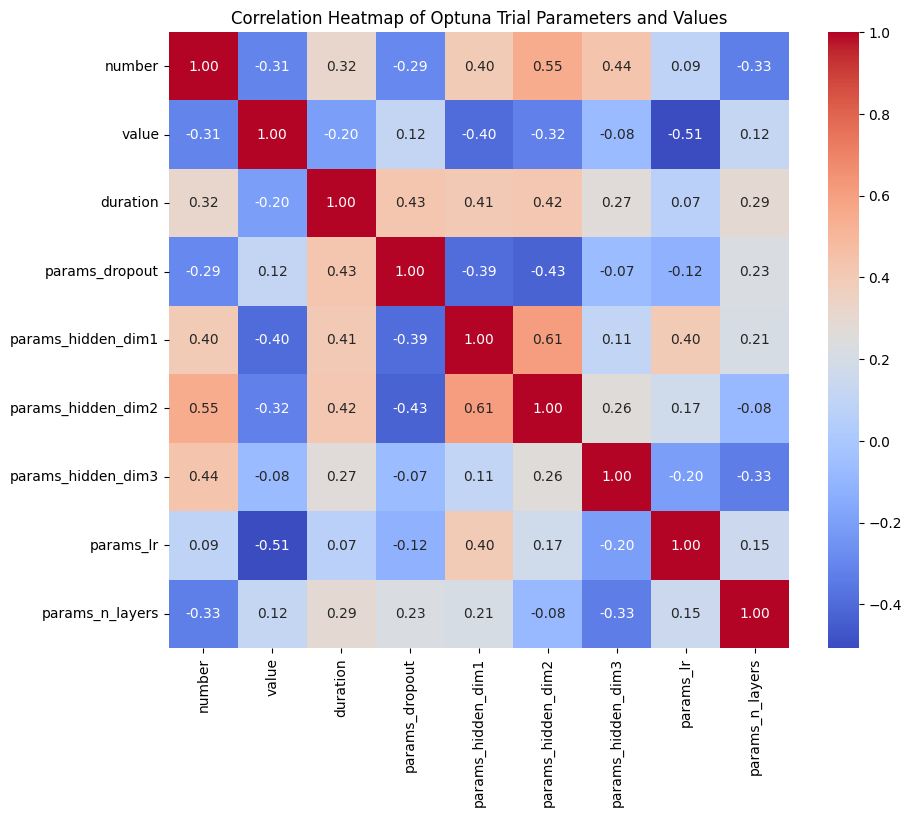

In [7]:
#plotting a heatmap of the optuna results
import seaborn as sns
import matplotlib.pyplot as plt

optuna_df = study.trials_dataframe()
plt.figure(figsize=(10, 8))
sns.heatmap(optuna_df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Optuna Trial Parameters and Values")
plt.show()

In [8]:
# === Extract best hyperparameters from Optuna ===
best_params = best_trial.params

# Build hidden layers tuple
n_layers = best_params["n_layers"]
best_hidden_dims = tuple([
    best_params["hidden_dim1"],
    best_params["hidden_dim2"],
    best_params["hidden_dim3"],
][:n_layers])

best_dropout = best_params["dropout"]
best_lr = best_params["lr"]

print("Using hidden_dims =", best_hidden_dims)
print("dropout =", best_dropout)
print("learning rate =", best_lr)


Using hidden_dims = (208, 224, 192)
dropout = 0.0
learning rate = 0.003633596393720295


Best config: medium_lr_high


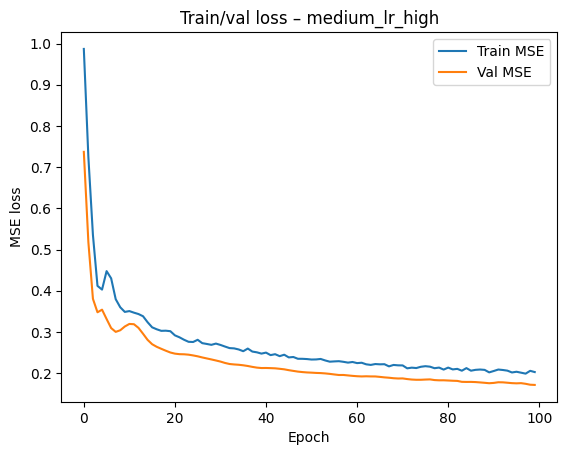

In [9]:
import matplotlib.pyplot as plt

y_pred_test_unscaled = y_scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_test_unscaled      = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting train/val loss curves for best config
best_name = results_df.sort_values("val_mse").iloc[0]["name"]
print("Best config:", best_name)

train_losses = histories[best_name]["train_losses"]
val_losses   = histories[best_name]["val_losses"]

plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses,   label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.title(f"Train/val loss – {best_name}")
plt.show()


Best Optuna params: {'hidden_dim1': 208, 'hidden_dim2': 224, 'hidden_dim3': 192, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.003633596393720295}
Using hidden_dims = (208, 224, 192) dropout = 0.0 lr = 0.003633596393720295


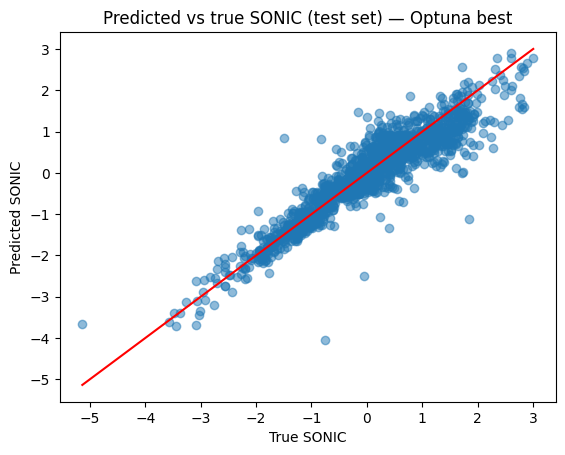

In [10]:
# Use Optuna best trial to rebuild & retrain the model, then plot preds vs true
params = best_trial.params
n_layers = params.get("n_layers", 2)
hidden_dims = tuple([params["hidden_dim1"], params["hidden_dim2"], params["hidden_dim3"]][:n_layers])
dropout = params.get("dropout", 0.0)
lr = params.get("lr", 1e-3)

print("Best Optuna params:", params)
print("Using hidden_dims =", hidden_dims, "dropout =", dropout, "lr =", lr)

# Reproducibility
torch.manual_seed(NP_RANDOM_SEED)
np.random.seed(NP_RANDOM_SEED)

# Build and train model using Optuna params
model = make_model(
    hidden_dims=hidden_dims,
    dropout=dropout,
    activation=nn.ReLU,
)
model, _, _, _ = train_model(
    model,
    X_train, y_train,
    X_val,   y_val,
    lr=lr,
    epochs=100,
    verbose=False,
)

# Predictions on test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).cpu().numpy()
y_true_test = y_test.cpu().numpy()

# Scatter plot
plt.figure()
plt.scatter(y_true_test, y_pred_test, alpha=0.5)
plt.xlabel("True SONIC")
plt.ylabel("Predicted SONIC")
plt.title("Predicted vs true SONIC (test set) — Optuna best")
plt.plot([y_true_test.min(), y_true_test.max()],
         [y_true_test.min(), y_true_test.max()], color="red")
plt.show()


[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 0: R² = 0.8661
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 1: R² = 0.8655
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 2: R² = 0.8501
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 3: R² = 0.8470
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 4: R² = 0.8646


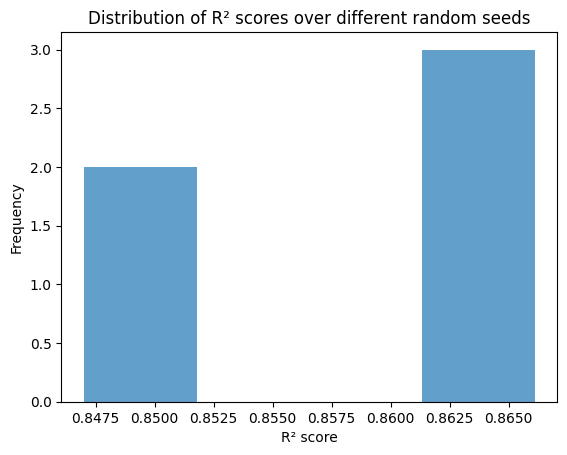

In [11]:
"""
Calculating R² score.
"""

from sklearn.metrics import r2_score

seeds = [0, 1, 2, 3, 4]
scores = []

for seed in seeds:
    # 1. new random split
    (X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(None)

    # 2. train model with same hyperparameters
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = make_model(  # use best params fra Optuna
        hidden_dims = hidden_dims,
        dropout = best_dropout,
        activation = nn.ReLU,
    )

    model, best_val_mse, train_losses, val_losses = train_model(
        model,
        X_train, y_train,
        X_val,   y_val,
        lr=best_lr,
        epochs=100,
        verbose=False,
    )

    # 3. evaluate on test
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)

    r2 = r2_score(
        y_test.numpy().ravel(),
        y_pred_test.numpy().ravel()
    )
    print(f"Seed {seed}: R² = {r2:.4f}")
    scores.append(r2)

print("R² scores:", scores)
print("Mean R²:", np.mean(scores))
print("Std  R²:", np.std(scores))

plt.figure()
plt.hist(scores, bins='auto', alpha=0.7)
plt.xlabel("R² score")
plt.ylabel("Frequency")
plt.title("Distribution of R² scores over different random seeds")
plt.show()



Ridge baseline:
Test MSE: 0.35456642508506775
Test R²: 0.6266187429428101


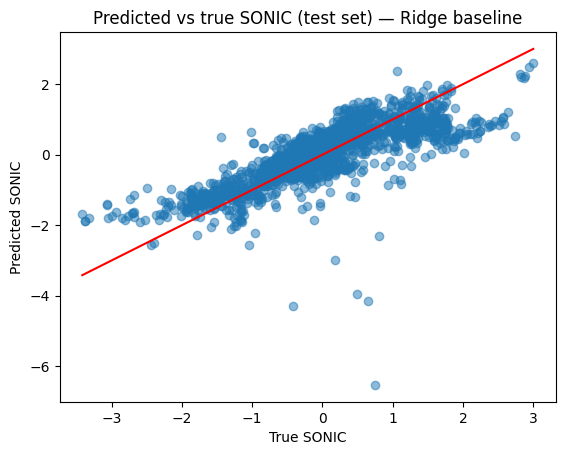

In [12]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Convert tensors to numpy
X_tr = X_train.numpy()
y_tr = y_train.numpy().ravel()
X_te = X_test.numpy()
y_te = y_test.numpy().ravel()

ridge = Ridge(alpha=1.0)
ridge.fit(X_tr, y_tr)

ridge_pred = ridge.predict(X_te)

ridge_mse = mean_squared_error(y_te, ridge_pred)
ridge_r2  = r2_score(y_te, ridge_pred)

print("Ridge baseline:")
print("Test MSE:", ridge_mse)
print("Test R²:", ridge_r2)

plt.figure()
plt.scatter(y_te, ridge_pred, alpha=0.5)
plt.xlabel("True SONIC")
plt.ylabel("Predicted SONIC")
plt.title("Predicted vs true SONIC (test set) — Ridge baseline")
plt.plot([y_te.min(), y_te.max()],
            [y_te.min(), y_te.max()], color="red")
plt.show()
